In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

# Go up 3 levels to the repo's root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add the repo root to sys.path
sys.path.append(repo_root)

from data_processing.helpers import normalize, sample
from models.initialization import init_single_net, neural_net, init_pinns, create_solution
from equations.simple_mass_conservation import gov_eqn
from models.optimization import adam_optimizer, lbfgs_optimizer

In [2]:
def load_fenics_results(csv, x_left=-2000, x_right=2000):
    df = pd.read_csv(f'{csv}')
    
    # Keep full df for interpolation, use filtered for main body
    df_filtered = df[(df['x'] > x_left) & (df['x'] < x_right)]
    df_surface = df_filtered[df_filtered['d'] <= 1e-6]

    new_rows = []

    # Interpolate at the divide (x = 0)
    for z_val in sorted(df['z'].unique()):
        df_z = df[df['z'] == z_val]
        if df_z['x'].min() <= 0 <= df_z['x'].max():
            df_z = df_z.sort_values('x')
            new_row = {
                'x': 0,
                'z': z_val,
            }
            for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                new_row[col] = np.interp(0, df_z['x'], df_z[col])
            new_rows.append(new_row)

    df_interp = pd.DataFrame(new_rows)
    df_combined = pd.concat([df_filtered, df_interp], ignore_index=True)
    df_divide = df_combined[df_combined['x'] == 0]

    # Interpolate at flanks (using the full df!)
    flank_rows = []
    for x_target in [x_left, x_right]:
        for z_val in sorted(df['z'].unique()):
            df_z = df[df['z'] == z_val]
            if df_z['x'].min() <= x_target <= df_z['x'].max():
                df_z = df_z.sort_values('x')
                row = {
                    'x': x_target,
                    'z': z_val,
                }
                for col in ['u', 'w', 'rho', 'p', 'mu', 'd']:
                    row[col] = np.interp(x_target, df_z['x'], df_z[col])
                flank_rows.append(row)
    df_flanks = pd.DataFrame(flank_rows)

    df_bed = df_filtered[df_filtered['z'] == 0]

    return df_filtered, df_surface, df_divide, df_bed, df_flanks

In [3]:
df_full, df_surf, df_divide, df_bed, df_flanks = load_fenics_results('../../data_processing/fenics_data.csv',2000,6000)

In [41]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [42]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [43]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [44]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [45]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_masscon(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        w_smp = data['smp'][1][:,1:2] # ground truth w
        x_div = data['div'][0]
        u_div = data['div'][1][:,0:1] # horizontal velocity at divide (should be 0)
        x_bed = data['bed'][0]
        w_bed = data['bed'][1][:,1:2] # ground truth w at bed (should be 0)
        rho_bed = data['bed'][1][:,2:3] # ground truth rho at bed (should be rho_i)
        x_surf = data['surf'][0]
        u_surf = data['surf'][1][:,0:1] # ground truth surface horizontal velocity 

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        w_pred = net(x_smp)[:, 1:2] # not 0:2 because we only have data in w

        # boundary constraints
        u_div_pred = net(x_div)[:,0:1]
        bed_pred = net(x_bed)
        w_bed_pred = bed_pred[:,1:2]
        rho_bed_pred = bed_pred[:,2:3]
        u_surf_pred = net(x_surf)[:,0:1]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(w_pred - w_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        div_err = ms_error(u_div_pred-u_div)
        rho_bed_err = ms_error(rho_bed-rho_bed_pred)
        w_bed_err = ms_error(w_bed-w_bed_pred)
        surf_err = ms_error(u_surf-u_surf_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(div_err) + jnp.sum(rho_bed_err) + jnp.sum(w_bed_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, div_err, rho_bed_err, w_bed_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [46]:
# create the loss function
NN_loss = create_loss_masscon(pred_u, gov_eqn, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [47]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 3.7022e-02 | Loss_d: 3.0503e-02 | Loss_e: 4.5934e-02 | Loss_b: 3.7708e-01
Step: 200 | Loss: 1.6681e-02 | Loss_d: 3.5185e-02 | Loss_e: 2.6612e-02 | Loss_b: 1.4254e-01
Step: 300 | Loss: 6.7169e-03 | Loss_d: 2.1418e-02 | Loss_e: 6.0412e-03 | Loss_b: 5.4823e-02
Step: 400 | Loss: 3.6031e-03 | Loss_d: 9.3134e-03 | Loss_e: 2.3839e-03 | Loss_b: 3.2440e-02
Step: 500 | Loss: 2.6016e-03 | Loss_d: 5.3544e-03 | Loss_e: 1.7814e-03 | Loss_b: 2.4733e-02
Step: 600 | Loss: 2.0680e-03 | Loss_d: 3.5546e-03 | Loss_e: 1.3683e-03 | Loss_b: 2.0409e-02
Step: 700 | Loss: 1.8793e-03 | Loss_d: 4.4286e-03 | Loss_e: 7.7683e-04 | Loss_b: 1.7816e-02
Step: 800 | Loss: 1.6587e-03 | Loss_d: 3.3563e-03 | Loss_e: 9.6390e-04 | Loss_b: 1.5999e-02
Step: 900 | Loss: 1.4368e-03 | Loss_d: 1.8719e-03 | Loss_e: 6.5581e-04 | Loss_b: 1.5073e-02
Step: 1000 | Loss: 1.4423e-03 | Loss_d: 2.8285e-03 | Loss_e: 6.8872e-04 | Loss_b: 1.4151e-02
Step: 1100 | Loss: 1.2714e-03 | Loss_d: 1.3138e-03 | Loss_e: 5.7138e-04 | Loss_

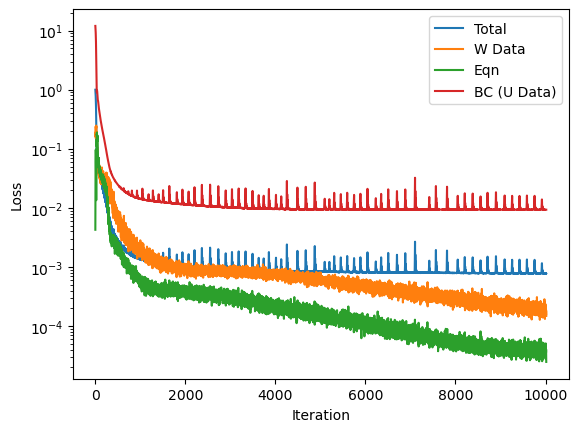

In [48]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [49]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 7.8331e-04 | Loss_d: 2.4545e-04 Loss_e: 3.7878e-05 | Loss_b: 9.3122e-03
Step: NaN | Loss: 1.1017e-03 | Loss_d: 5.0289e-04 Loss_e: 1.5959e-04 | Loss_b: 1.2833e-02
Step: NaN | Loss: 7.8184e-04 | Loss_d: 2.2212e-04 Loss_e: 3.7589e-05 | Loss_b: 9.3177e-03
Step: NaN | Loss: 7.8094e-04 | Loss_d: 2.0801e-04 Loss_e: 3.8038e-05 | Loss_b: 9.3205e-03
Step: NaN | Loss: 7.9094e-04 | Loss_d: 1.8533e-04 Loss_e: 4.5145e-05 | Loss_b: 9.4585e-03
Step: NaN | Loss: 7.8093e-04 | Loss_d: 2.0609e-04 Loss_e: 3.8158e-05 | Loss_b: 9.3221e-03
Step: NaN | Loss: 7.8088e-04 | Loss_d: 2.0552e-04 Loss_e: 3.8110e-05 | Loss_b: 9.3221e-03
Step: NaN | Loss: 7.8086e-04 | Loss_d: 2.0347e-04 Loss_e: 3.8032e-05 | Loss_b: 9.3240e-03
Step: NaN | Loss: 7.8084e-04 | Loss_d: 2.0430e-04 Loss_e: 3.8042e-05 | Loss_b: 9.3229e-03
Step: NaN | Loss: 7.8080e-04 | Loss_d: 2.0416e-04 Loss_e: 3.8054e-05 | Loss_b: 9.3225e-03
Step: NaN | Loss: 7.8072e-04 | Loss_d: 2.0417e-04 Loss_e: 3.8511e-05 | Loss_b: 9.3211e-03
Step: NaN 

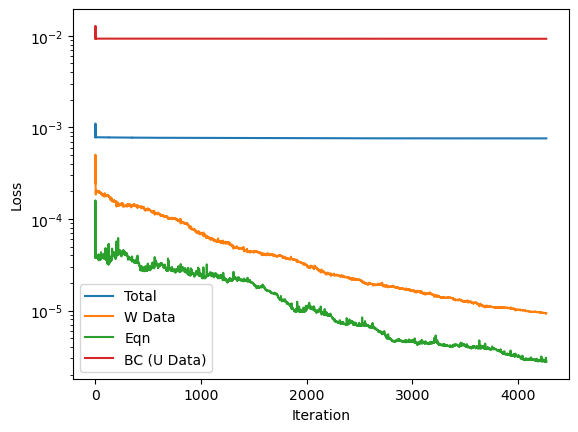

In [50]:
plot_loss(loss2)

In [51]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values

In [52]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*info['w_range']/info['z_range']
results['e0']=eqn[:, 0:1] * term0
results['e01']=term[:, 0:1] * term0
results['e02']=term[:, 1:2] * term0

Text(0, 0.5, 'Predicted - Ground')

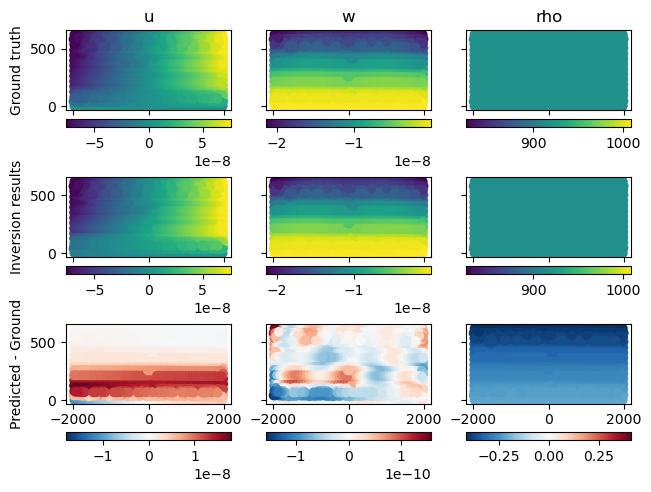

In [53]:
from matplotlib import colors

fig, axs = plt.subplots(nrows=3,ncols=3,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
    fig.colorbar(new_c, ax=axs[1, i], location='bottom')
    axs[0,i].set_title(f'{key}')

    diff = results[f'{key}_p'].flatten()-results[f'{key}_g']
    c = axs[2,i].scatter(results['x'],results['z'],c=diff,cmap='RdBu_r',norm=colors.CenteredNorm())
    fig.colorbar(c, ax=axs[2, i], location='bottom')

axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')
axs[2][0].set_ylabel('Predicted - Ground')



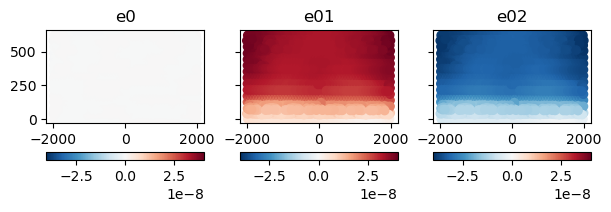

In [54]:
# check equation physics
fig, axs = plt.subplots(figsize = (6,2),ncols=3,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e0'],results['e01'],results['e02']]))
for i, key in enumerate(['e0','e01','e02']):
    c = axs[i].scatter(results['x'],results['z'],c=results[key],vmin=-vmax,vmax=vmax,cmap='RdBu_r')
    fig.colorbar(c, ax=axs[i], location='bottom')
    axs[i].set_title(key)

# Now, we test just momentum

In [4]:
from equations.momentum_conservation import gov_eqn as gov_eqn_momentum


In [20]:
# generate PINN
# select a random seed
seed = 1234 #2134
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4) # NEED TO UPDATE 4 to relevant number
n_hl = 6
n_unit = 30
# initialize the weights and biases of the network
trained_params = init_pinns(keys[0], n_hl, n_unit)

In [21]:
# normalize
df_norm,df_bcs,info = normalize(df_full, df_surf, df_divide, df_bed, df_flanks)
# df_bcs contains the data for surface, divide,bed and flanks

In [22]:
pred_u = create_solution(df_bcs[0]) # need to modify as well


In [23]:
# for adam
n_samples = jnp.array([200,200]) # small number for now
dataf = sample(df_norm,n_samples,df_bcs) # nsamples is for data loss + colocation points
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])

# for L-BFGS
n_pt2 = n_samples * 2
dataf_l = sample(df_norm, n_pt2,df_bcs)
key_lbfgs = random.split(keys[2], 5)

In [24]:
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def create_loss_momentum(predf,gov_eqn,scales,lw):
    # for now do 3 lw weights: data, eqn, bc
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        net = lambda z: predf(params, z)
        
        # load the ground truth for dataloss
        x_smp = data['smp'][0]
        U_smp = data['smp'][1][:,0:3] # ground truth u,w,rho 
        # assuming only surface ice pressure is known
        x_surf = data['surf'][0]
        p_surf = data['surf'][1][:,3:4] # ground truth surface ice pressure
        
        # assuming known viscosities at flanks
        x_flanks = data['flanks'][0]
        mu_flanks = data['flanks'][1][:,4:5] # doing viscosities at flank

        # load the position and weight of collocation points
        x_col = data['col'][0]

        # calculate the predicted variables
        U_pred = net(x_smp)[:, 0:3] # predicting u, w, rho

        # boundary constraints
        p_surf_pred = net(x_surf)[:,3:4]
        mu_flanks_pred = net(x_flanks)[:,4:5]
        
        # calculate the residue of equation
        f_pred,terms = gov_eqn(net, x_col, scales)

        # calculate the mean squared root error of data
        data_err = ms_error(U_pred - U_smp)

        # calculate the mean squared root error of equation
        eqn_err = ms_error(f_pred)

        # calculate errors of boundary conditions
        surf_err = ms_error(p_surf-p_surf_pred)
        flanks_err = ms_error(mu_flanks-mu_flanks_pred)

        # all errors should be 1d arrays
        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err)
        loss_eqn = jnp.sum(eqn_err)
        loss_bd = jnp.sum(flanks_err) + jnp.sum(surf_err)

        loss_ref = loss_fun.lref
        # calculate total loss

        # lw should have 3 weights
        loss = (lw[0]*loss_data + lw[1]*loss_eqn + lw[2]*loss_bd ) / loss_ref
        
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, flanks_err,surf_err])
        return loss, loss_info

    loss_fun.lref = 1.0
    return loss_fun

In [25]:
# create the loss function
NN_loss = create_loss_momentum(pred_u, gov_eqn_momentum, info, [1,1,1])
# calculate the initial loss and set it as the reference value for loss
NN_loss.lref = NN_loss(trained_params, data)[0]

In [26]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 10000

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 100 | Loss: 9.2222e-02 | Loss_d: 2.5822e+00 | Loss_e: 2.9472e-02 | Loss_b: 3.1539e-01
Step: 200 | Loss: 3.7757e-02 | Loss_d: 8.9348e-01 | Loss_e: 2.5676e-02 | Loss_b: 2.7923e-01
Step: 300 | Loss: 1.3350e-02 | Loss_d: 1.4080e-01 | Loss_e: 1.4223e-02 | Loss_b: 2.6869e-01
Step: 400 | Loss: 1.3071e-02 | Loss_d: 1.3540e-01 | Loss_e: 1.2724e-02 | Loss_b: 2.6672e-01
Step: 500 | Loss: 1.0886e-02 | Loss_d: 7.2354e-02 | Loss_e: 7.5347e-03 | Loss_b: 2.6563e-01
Step: 600 | Loss: 9.5614e-03 | Loss_d: 3.4324e-02 | Loss_e: 4.2047e-03 | Loss_b: 2.6494e-01
Step: 700 | Loss: 8.7671e-03 | Loss_d: 1.1091e-02 | Loss_e: 2.7379e-03 | Loss_b: 2.6443e-01
Step: 800 | Loss: 8.5539e-03 | Loss_d: 4.9203e-03 | Loss_e: 2.5705e-03 | Loss_b: 2.6400e-01
Step: 900 | Loss: 8.6061e-03 | Loss_d: 7.6406e-03 | Loss_e: 1.8201e-03 | Loss_b: 2.6369e-01
Step: 1000 | Loss: 8.5542e-03 | Loss_d: 6.7604e-03 | Loss_e: 1.2789e-03 | Loss_b: 2.6347e-01
Step: 1100 | Loss: 8.4153e-03 | Loss_d: 2.7950e-03 | Loss_e: 8.3137e-04 | Loss_

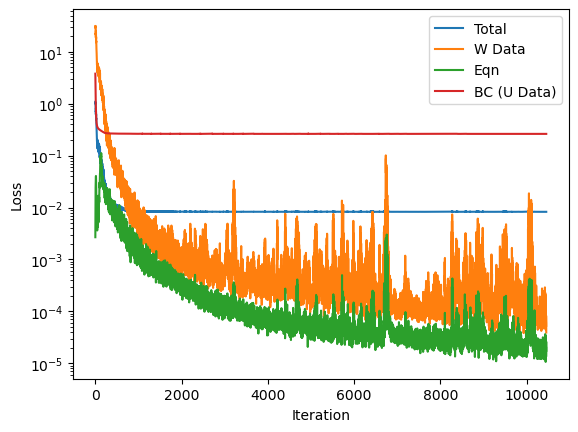

In [27]:
def plot_loss(loss):
  np_loss = np.array(loss)
  plt.semilogy(np_loss[:,0],label='Total')
  plt.semilogy(np_loss[:,1],label='W Data')
  plt.semilogy(np_loss[:,2],label='Eqn')
  plt.semilogy(np_loss[:,3],label='BC (U Data)')
  plt.legend()
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
plot_loss(loss1)

In [28]:
# set the training iteration
epoch2 = 10000
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs[1])

# training with L-bfgs
trained_params2, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)


Step: NaN | Loss: 8.2758e-03 | Loss_d: 5.3117e-05 Loss_e: 2.5994e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2878e-03 | Loss_d: 4.3406e-04 Loss_e: 2.4634e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2754e-03 | Loss_d: 4.6318e-05 Loss_e: 2.1119e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2753e-03 | Loss_d: 4.3178e-05 Loss_e: 1.9218e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2757e-03 | Loss_d: 5.8711e-05 Loss_e: 1.6074e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2752e-03 | Loss_d: 4.2900e-05 Loss_e: 1.7704e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2751e-03 | Loss_d: 4.1061e-05 Loss_e: 1.6553e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2764e-03 | Loss_d: 8.2733e-05 Loss_e: 1.7003e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2751e-03 | Loss_d: 4.1100e-05 Loss_e: 1.6506e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2751e-03 | Loss_d: 4.0619e-05 Loss_e: 1.6352e-05 | Loss_b: 2.6259e-01
Step: NaN | Loss: 8.2751e-03 | Loss_d: 4.0507e-05 Loss_e: 1.5856e-05 | Loss_b: 2.6259e-01
Step: NaN 

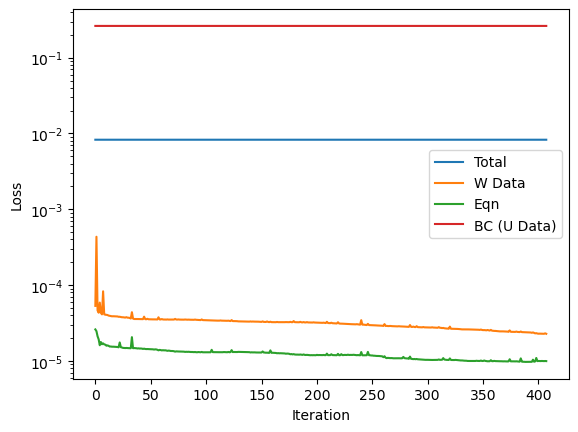

In [29]:
plot_loss(loss2)

In [30]:
# now lets make a prediction - this cell likely does not need to be changed
from equations.gradients import *
f_u = lambda x: pred_u(trained_params2, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:10]
f_eqn = lambda x: gov_eqn_momentum(f_u, x, info)

x_pred = df_norm[['x','z']].values
uw_rho_pmu = f_u(x_pred)
# set the partition number
nsp = 4
# separate input into different partition to avoid GPU memory limit
x_psp = jnp.array_split(x_pred, nsp)
idxsp = jnp.arange(nsp).tolist()
# calculate the derivative of network output at the velocity-data positions
du_list = tree_map(lambda x: f_gu(x_psp[x]), idxsp)
# calculate the associated equation residue of the trained network
eqnterm_list = tree_map(lambda x: f_eqn(x_psp[x]), idxsp)
eqn_list = tree_map(lambda x: eqnterm_list[x][0], idxsp)
term_list = tree_map(lambda x: eqnterm_list[x][1], idxsp)
# combine the sub-group list into a long array
duw_rho_pmu = jnp.vstack(du_list)
eqn = jnp.vstack(eqn_list)
term = jnp.vstack(term_list)
results = {}
for i,key in enumerate(['u','w','rho','p','mu']):
    results[f'{key}_g'] = df_full[key].values
    results[f'{key}_p'] = uw_rho_pmu[:,i:i+1]*info[f'{key}_range'] + info[f'{key}_mean']
    results[f'{key}x_p'] = duw_rho_pmu[:,2*i:2*i+1] * info[f'{key}_range']/info['x_range']
    results[f'{key}z_p'] = duw_rho_pmu[:,2*i+1:2*i+2] * info[f'{key}_range']/info['z_range']
    
results['x'] = df_full['x'].values
results['z'] = df_full['z'].values


In [31]:
# predicting equation terms is unique to each model
term0 = info['rho_range']*9.81*info['z_range']/info['x_range']
results['e1']=eqn[:, 0:1] * term0
results['e11']=term[:, 0:1] * term0
results['e12']=term[:, 1:2] * term0
results['e13']=term[:, 2:3] * term0

term1 = info['rho_range']*9.81
results['e2']=eqn[:, 1:2] * term1
results['e21']=term[:, 3:4] * term1
results['e22']=term[:, 4:5] * term1
results['e23']=term[:, 5:6] * term1

Text(0, 0.5, 'Predicted - Ground')

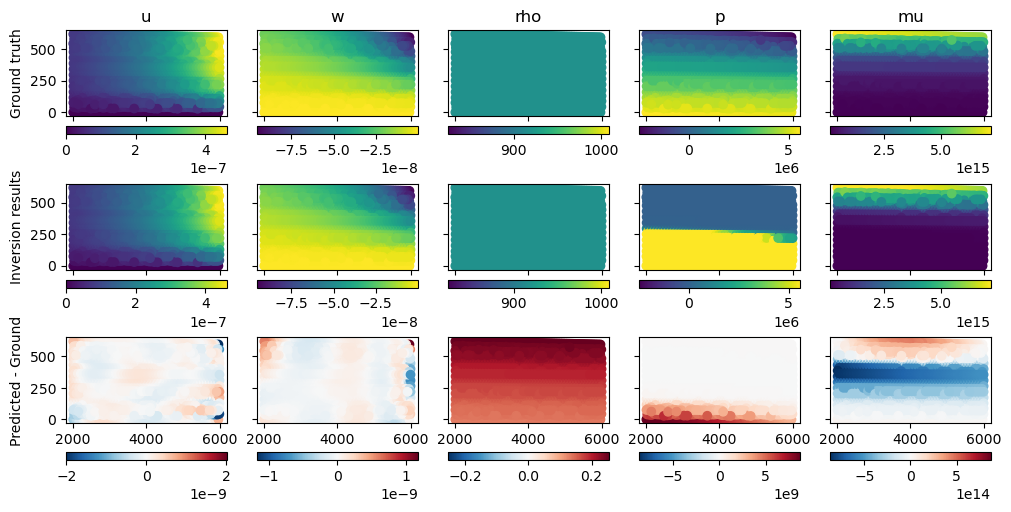

In [32]:
from matplotlib import colors

fig, axs = plt.subplots(figsize=(10,5),nrows=3,ncols=5,layout='constrained',sharex=True,sharey=True)
for i,key in enumerate(['u','w','rho','p','mu']):
    c = axs[0,i].scatter(results['x'],results['z'],c=results[f'{key}_g'])
    fig.colorbar(c, ax=axs[0, i], location='bottom')
    new_c = axs[1, i].scatter(results['x'], results['z'], 
                          c=results[f'{key}_p'], 
                          cmap=c.cmap, norm=c.norm)
    fig.colorbar(new_c, ax=axs[1, i], location='bottom')
    axs[0,i].set_title(f'{key}')

    diff = results[f'{key}_p'].flatten()-results[f'{key}_g']
    c = axs[2,i].scatter(results['x'],results['z'],c=diff,cmap='RdBu_r',norm=colors.CenteredNorm())
    fig.colorbar(c, ax=axs[2, i], location='bottom')

axs[0][0].set_ylabel('Ground truth')
axs[1][0].set_ylabel('Inversion results')
axs[2][0].set_ylabel('Predicted - Ground')



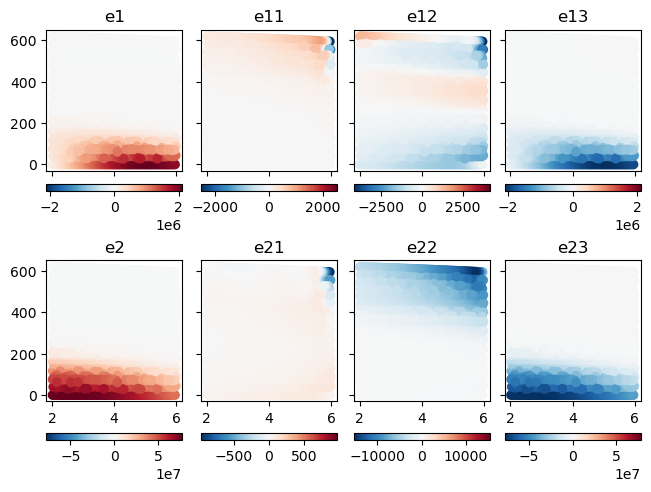

In [33]:
# check equation physics
from matplotlib import colors
fig, axs = plt.subplots(ncols=4,nrows=2,layout='constrained',sharex=True,sharey=True)
vmax = np.max(np.abs([results['e1'],results['e11'],results['e12'],results['e13'],
                     results['e2'],results['e21'],results['e22'],results['e23']]))

c=axs[0,0].scatter(results['x']/1000,results['z'],c=results['e1'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[0,0], location='bottom')
axs[0,0].set_title('e1')
c = axs[1,0].scatter(results['x']/1000,results['z'],c=results['e2'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
fig.colorbar(c, ax=axs[1,0], location='bottom')
axs[1,0].set_title('e2')

for i in range(3):
    c = axs[0,i+1].scatter(results['x']/1000,results['z'],c=results[f'e1{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[0,i+1], location='bottom')
    axs[0,i+1].set_title(f'e1{i+1}')

    c = axs[1,i+1].scatter(results['x']/1000,results['z'],c=results[f'e2{i+1}'],cmap='RdBu_r',norm=colors.CenteredNorm())#vmin=-vmax,vmax=vmax)
    fig.colorbar(c, ax=axs[1,i+1], location='bottom')
    axs[1,i+1].set_title(f'e2{i+1}')